<a href="https://colab.research.google.com/github/rghimre3/INFO5505_Machine_Learning_for_Data_Scientist/blob/main/Brain_Tumor_MRI_Classification_NNI_implementation_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [1]:
import os #The OS module in Python provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc.
import glob #In Python, the glob module is used to retrieve files/pathnames matching a specified pattern.
from tqdm.notebook import tqdm #TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.

import matplotlib.pyplot as plt #Pyplot provides the state-machine interface to the underlying plotting library in matplotlib.
import cv2  #OpenCV-Python is a library of Python bindings designed to solve computer vision problems. OpenCV-Python makes use of Numpy, which is a highly optimized library for numerical operations. All the OpenCV array structures are converted to and from Numpy arrays.

import numpy as np #NumPy used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.
import pandas as pd #Pandas is mainly used for data analysis. Pandas allows importing data from various file formats such as comma-separated values, JSON, SQL, Microsoft Excel. Pandas allows various data manipulation operations such as merging, reshaping, selecting, as well as data cleaning.
from random import sample # Randomly picking more than one element from the list without repeating elements it returns a list of unique items chosen randomly from the list, sequence, or set.

from sklearn.cluster import KMeans
#K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided.
#1.Clusters the data into k groups where k  is predefined.
#2.Select k points at random as cluster centers.
#3.Assign objects to their closest cluster center according to the Euclidean distance function.
#4.Calculate the centroid or mean of all objects in each cluster.
#5.Repeat steps 2, 3 and 4 until the same points are assigned to each cluster in consecutive rounds

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# **Image Data Loading**

In [9]:
def load_img(path, resize=None):
    img= cv2.imread(path, 0) #It loads an image from the specified file cv2.imread(path,flag)
                             #path: String representing the path of the image to be read
                             #flag: It specifies the way in which image should be read
                                    #1- imread-color
                                    #0- imread-graysclae
    if resize:
        img= cv2.resize(img, resize)   #if overfit or not fit 
    return img

In [11]:
dir_path= 'gdrive/MyDrive/Deep_Learning_Course_Project/archive/brain_tumor_dataset'
tumor_set=[] #creating empty set to gather data
non_tumor_set=[]

for label in os.listdir(dir_path): #for subfiles
    if label=='yes':
        path= os.path.join(dir_path, label)
        for img_path in tqdm(sample(glob.glob(path + '/*'), 30)): #creating seperate pipeline
            tumor_set.append(load_img(img_path))
    else:
        path= os.path.join(dir_path, label)
        for img_path in tqdm(sample(glob.glob(path + '/*'), 30)):
            non_tumor_set.append(load_img(img_path))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

# **Visualizing with Colormaps**

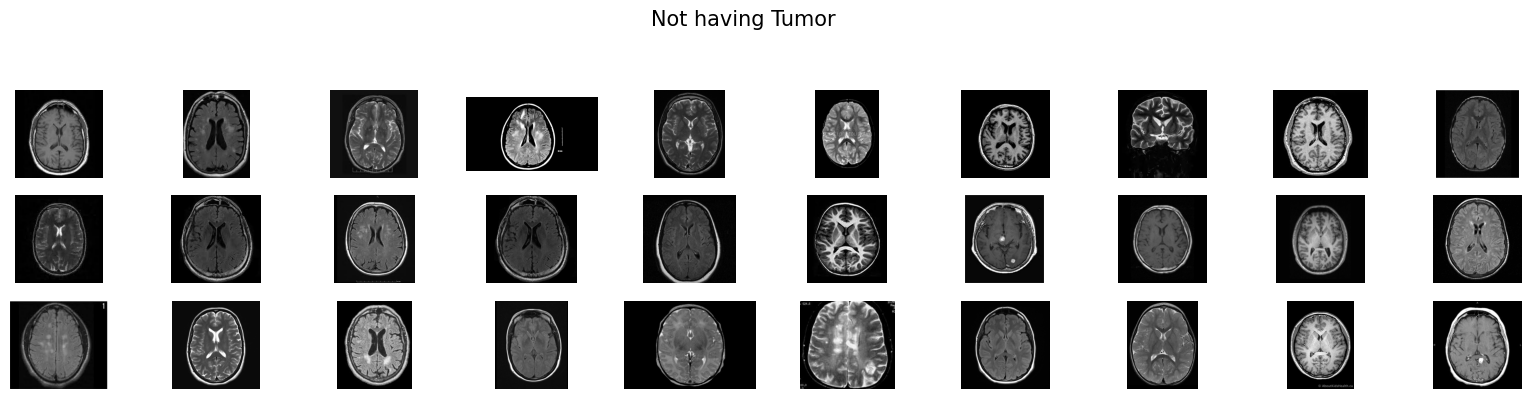

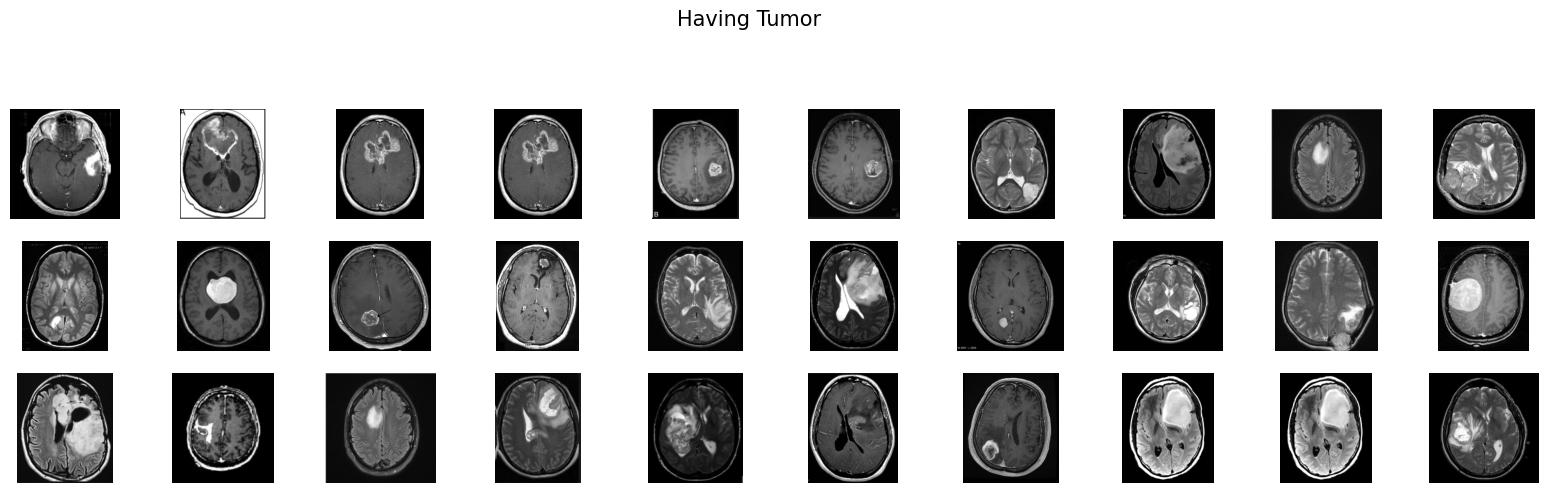

In [12]:
plt.figure(figsize=(20,8))
c=1
for i in range(30):
    plt.subplot(6,10,c) #figure has 6 rows,10coloums and this is the first plot
    plt.imshow(non_tumor_set[i], 'gray') #'gary' represents pixels are to be in gray
    plt.axis('off')
    c+=1    
plt.suptitle('Not having Tumor', size=15)
plt.show()


plt.figure(figsize=(20,10))
c=1
for i in range(30):
    plt.subplot(6,10,c)
    plt.imshow(tumor_set[i], 'gray')
    plt.axis('off')
    c+=1  
plt.suptitle('Having Tumor', size=15)
plt.show()

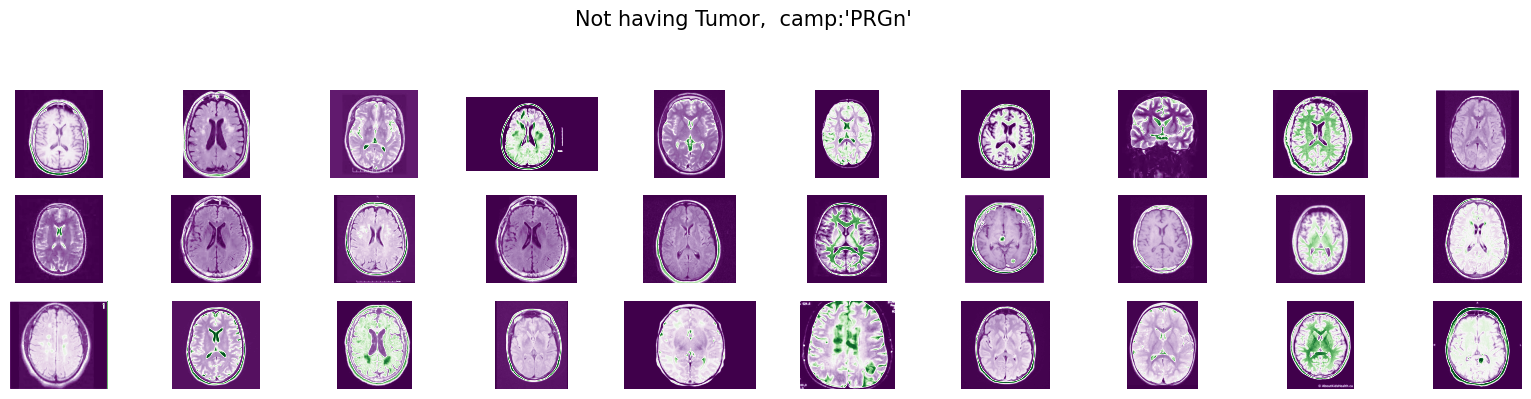

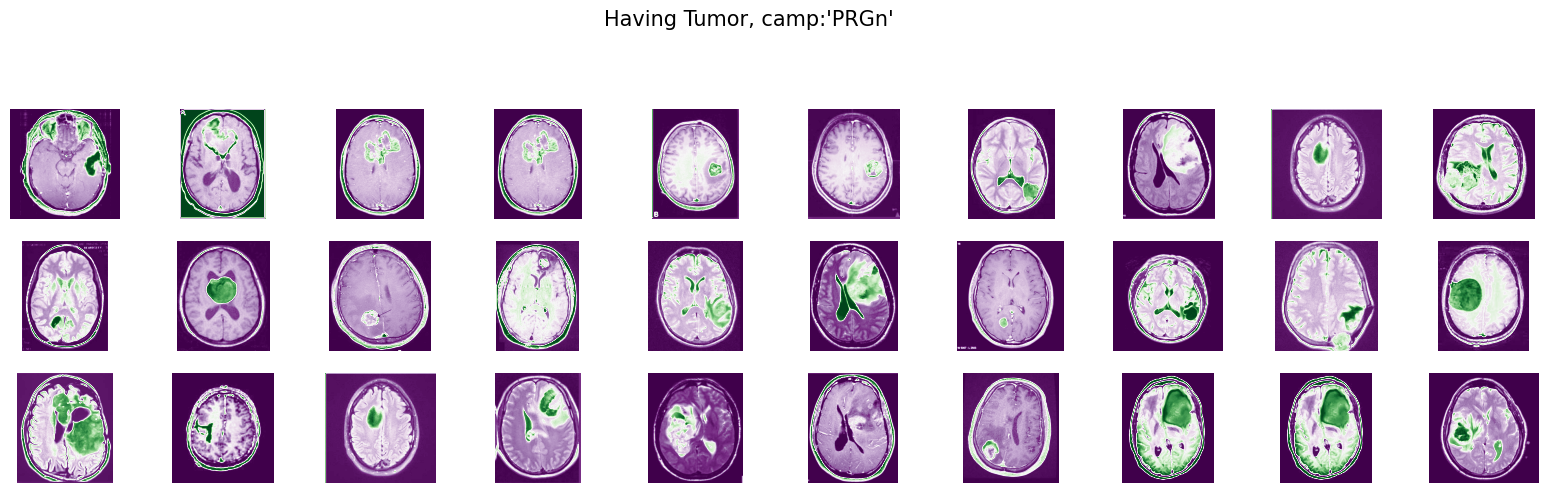

In [13]:
plt.figure(figsize=(20,8))
c=1
for i in range(30):
    plt.subplot(6,10,c)
    plt.imshow(non_tumor_set[i], 'PRGn')
    plt.axis('off')
    c+=1    
plt.suptitle("Not having Tumor,  camp:'PRGn'", size=15)
plt.show()


plt.figure(figsize=(20,10))
c=1
for i in range(30):
    plt.subplot(6,10,c)
    plt.imshow(tumor_set[i], 'PRGn')
    plt.axis('off')
    c+=1  
plt.suptitle("Having Tumor, camp:'PRGn'", size=15)
plt.show()

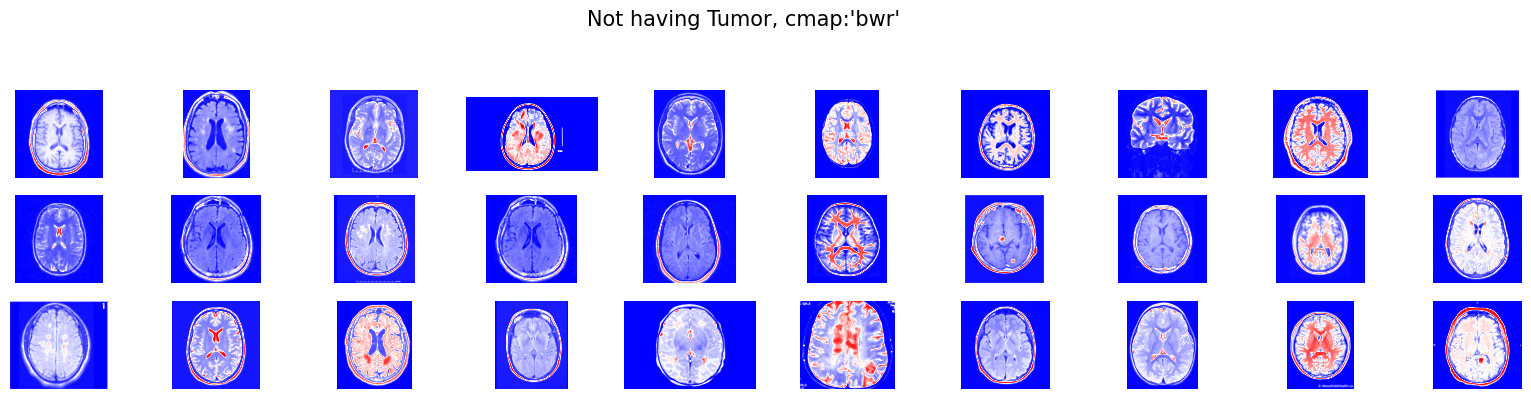

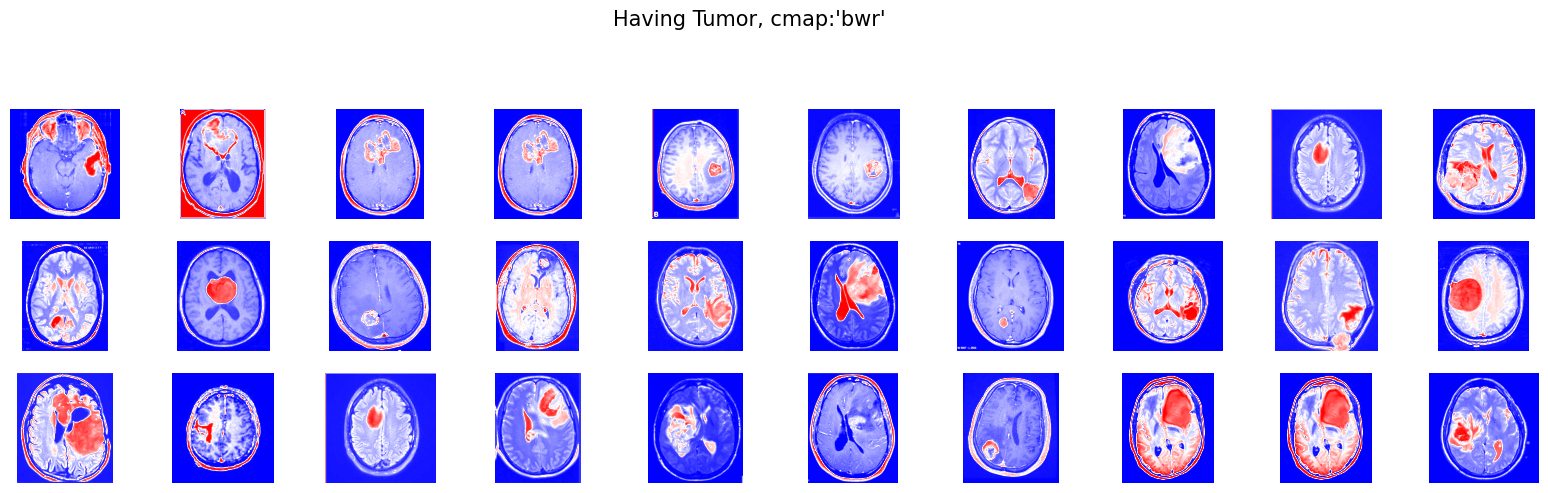

In [14]:
plt.figure(figsize=(20,8))
c = 1
for i in range(30):
    plt.subplot(6,10,c)
    plt.imshow(non_tumor_set[i], 'bwr')
    plt.axis('off')
    c +=1
       
plt.suptitle("Not having Tumor, cmap:'bwr'", size=15)
plt.show()


plt.figure(figsize=(20,10))
c=1
for i in range(30):
    plt.subplot(6,10,c)
    plt.imshow(tumor_set[i], 'bwr')
    plt.axis('off')
    c+=1  
plt.suptitle("Having Tumor, cmap:'bwr'", size=15)
plt.show()

# **Equalized Hist**

In [16]:
#Adaptive histogram equalization: AHE used to increase contrast of the image
def adaptive_hist(img, clipLimit= 4.0):
    window= cv2.createCLAHE(clipLimit= clipLimit, tileGridSize=(8, 8)) 
            #contrast limited AHE(CLAHE) it limits the amplification by cliping the histogram at a predefined value before compate.
            #tilegridsize refers to size of grid for histogram equation input image will be divided into equally sized rectanglar tiles. tile grid size defines the number of tiles in row, color.
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
            #cv2.cvtcolor(img,code)
            #code:color space conversion code
            #cv2.cv2color-BGR2Lab: This code is used to change the BGR color space to Lab color space

    ch1, ch2, ch3 = cv2.split(img_lab)
            #cv2,split() function splits the source multichannel img to several channel images
           
    img_l = window.apply(ch1)
    img_clahe = cv2.merge((img_l, ch2, ch3))
    return cv2.cvtColor(img_clahe, cv2.COLOR_Lab2BGR)
           #cv2.merge function merges several single-channel images into multichannel image.

# **K-Means clustering**

In [18]:
#cv2.kmeans(samples, nclusters(k), criteria, attempts,flags) this function for color clustering
#nclusters(k): number of clusters reqiured at the end
def k_means(img, n_colors= 2):
    w, h, d = original_shape = tuple(img.shape)
    img= img/255.0
    #to turn 3D image into 2D .By dividing the values are in a range from 0 to 1
    image_array = np.reshape(img, (w * h, d))
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array)
    labels = kmeans.predict(image_array)
    
    """Recreate the (compressed) image from the code book & labels"""
    codebook= kmeans.cluster_centers_
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0.98, 'Normal Brain MRI scan')

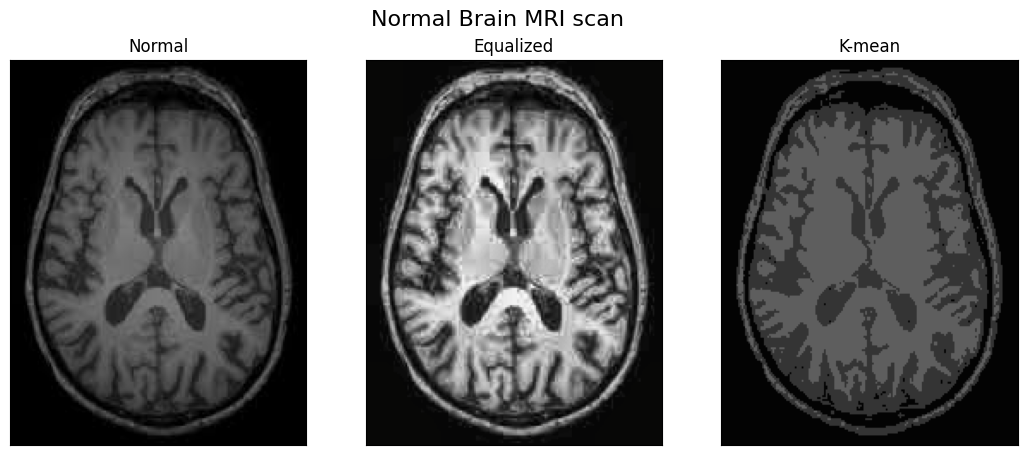

In [20]:
img_path= 'gdrive/MyDrive/Deep_Learning_Course_Project/archive/brain_tumor_dataset/no/10 no.jpg' 

f, ax= plt.subplots(1, 3, figsize=(13,5))
img= cv2.imread(img_path)
eq_hist_img= adaptive_hist(img)
kmeans_img= k_means(img,3)

ax[0].imshow(img, aspect='auto')
ax[0].set_xticks([]); ax[0].set_yticks([]); ax[0].set_title('Normal')
ax[1].imshow(eq_hist_img,  aspect='auto')
ax[1].set_xticks([]); ax[1].set_yticks([]); ax[1].set_title('Equalized')
ax[2].imshow(kmeans_img,  aspect='auto')
ax[2].set_xticks([]); ax[2].set_yticks([]); ax[2].set_title('K-mean')

plt.suptitle('Normal Brain MRI scan', size=16)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0.98, 'Unhealthy Brain(Tumor) MRI scan')

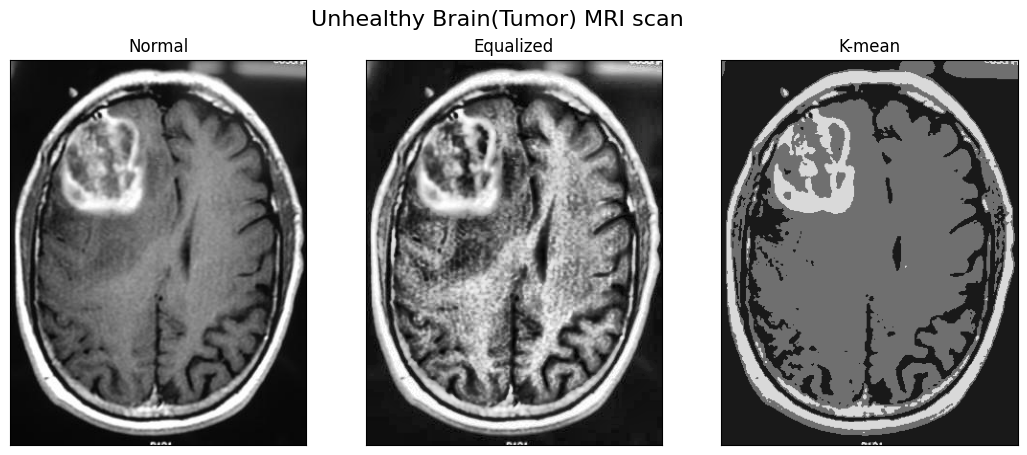

In [21]:

img_path= 'gdrive/MyDrive/Deep_Learning_Course_Project/archive/brain_tumor_dataset/yes/Y15.jpg'

f, ax= plt.subplots(1, 3, figsize=(13,5))
img= cv2.imread(img_path)
eq_hist_img= adaptive_hist(img)
kmeans_img= k_means(img,3)

ax[0].imshow(img, aspect='auto')
ax[0].set_xticks([]); ax[0].set_yticks([]); ax[0].set_title('Normal')
ax[1].imshow(eq_hist_img,  aspect='auto')
ax[1].set_xticks([]); ax[1].set_yticks([]); ax[1].set_title('Equalized')
ax[2].imshow(kmeans_img,  aspect='auto')
ax[2].set_xticks([]); ax[2].set_yticks([]); ax[2].set_title('K-mean')

plt.suptitle('Unhealthy Brain(Tumor) MRI scan', size=16)

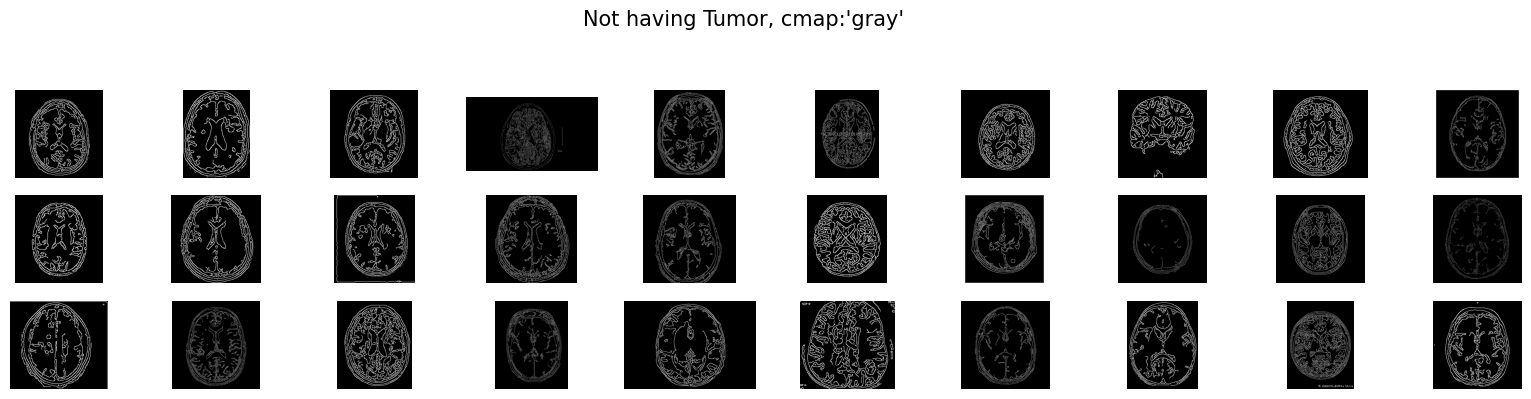

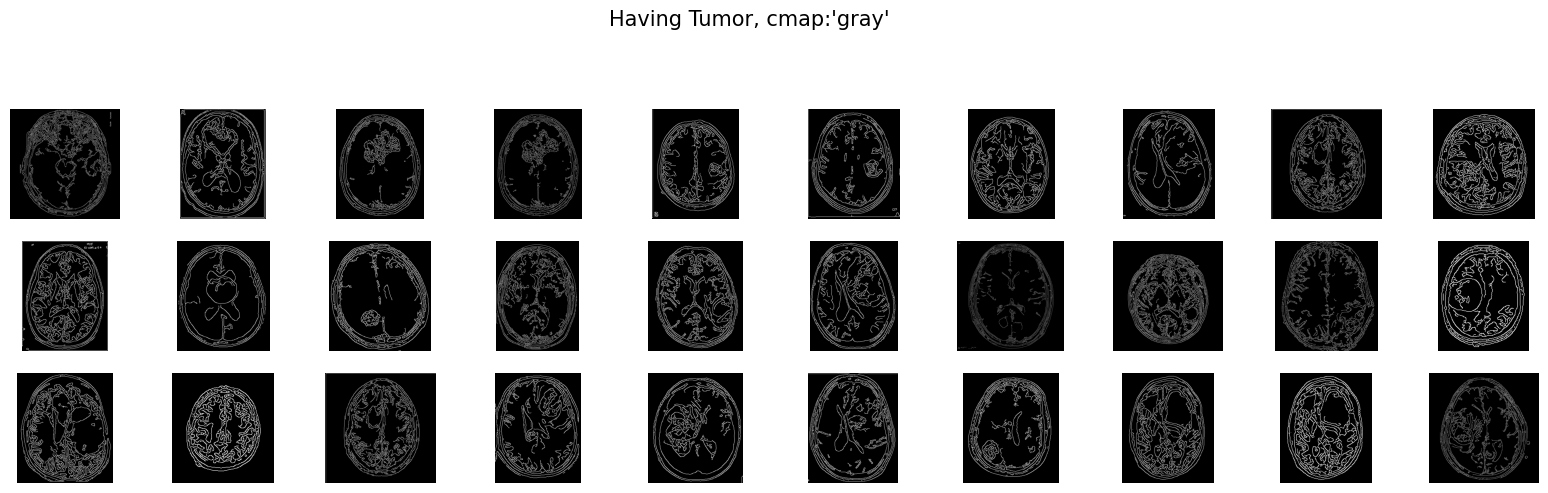

In [22]:
plt.figure(figsize=(20,8))
c=1
for i in range(30):
    plt.subplot(6,10,c)
    ed= cv2.medianBlur(non_tumor_set[i], 5)
    #the central element of the image is replaced by the median of all the pixels in the kernel area. This operation processes the edges while removing the noise.
    ed= cv2.Canny(ed,100,20)
    #Canny Edge Detection is used to detect the edges in an image. It accepts a gray scale image as input and it uses a multistage algorithm.
    #image − A Mat object representing the source (input image) for this operation.
    #edges − A Mat object representing the destination (edges) for this operation.
    #threshold1 − A variable of the type double representing the first threshold for the hysteresis procedure.
    #threshold2 − A variable of the type double representing the second threshold for the hysteresis procedure
    plt.imshow(ed, 'gray')
    plt.axis('off')
    c+=1    
plt.suptitle("Not having Tumor, cmap:'gray'", size=15)
plt.show()


plt.figure(figsize=(20,10))
c=1
for i in range(30):
    plt.subplot(6,10,c)
    ed= cv2.medianBlur(tumor_set[i], 5)
    ed= cv2.Canny(ed,100,20)
    plt.imshow(ed, 'gray')
    plt.axis('off')
    c+=1  
plt.suptitle("Having Tumor, cmap:'gray'", size=15)
plt.show()

# **Model traning with transfer learning**

In [23]:
import tensorflow
#ImageDataGenerator:it generates batches of tensor image data with realtime data augmentation. The output images generated by the generator will have the same output dimensions are as the input images.

#preprocess_input: the preprocess input function is meant to adequate your image to the format the model requires.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, Input
#Each layer receives input information, do some computation and finally output the transformed information. The output of one layer will flow into the next layer as its input.
from tensorflow.keras.models import Model
#Model groups layers into an object with training and inference features

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
#The classification report visualizer displays the precision, recall, F1, and support scores for the model.
# The matrix compares the actual target values with those predicted by the machine learning model.
#Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.05,#The width_shift_range is a floating point number between 0.0 and 1.0 which specifies the upper bound of the fraction of the total width by which the image is to be randomly shifted, either towards the left or right. 
    rotation_range=12, #By specifying the rotation_range , the data generated is randomly rotated by an angle in the range of +rotation_range to -rotation_range (in degrees).
    shear_range=0.2,#Shear transformation slants the shape of the image. This is different from rotation in the sense that in shear transformation, we fix one axis and stretch the image at a certain angle known as the shear angle. This creates a sort of ‘stretch’ in the image, which is not seen in rotation. shear_range specifies the angle of the slant in degrees.
    vertical_flip=True,#The generator will generate images, which on a random basis, will be vertically flipped
    horizontal_flip=True,#The generator will generate images, which on a random basis, will be horizontally flipped
    validation_split=0.1225) # set validation split

In [26]:
train_data_dir= 'gdrive/MyDrive/Deep_Learning_Course_Project/archive/brain_tumor_dataset/'

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=26,
    class_mode='binary',
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(224, 224),
    batch_size= 30,
    class_mode='binary',
    subset='validation') # set as validation data

Found 223 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [27]:
train_generator.class_indices

{'no': 0, 'yes': 1}

In [28]:
def build_model():
    vgg= VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    vgg.layers
    for layer in vgg.layers:
        layer.trainable= False
    x= layers.Flatten()(vgg.output) #A flatten operation on a tensor reshapes the tensor to have the shape that is equal to the number of elements contained in tensor non including the batch dimension.
    x= layers.Dropout(0.25)(x) #Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.
    x= layers.Dense(1024, activation='relu')(x)
    #Dense layer is the regular deeply connected neural network layer. It is most common and frequently used layer. Dense layer does the operation on the input and return the output.
    x= layers.Dropout(0.15)(x)
    out= layers.Dense(1, activation='sigmoid')(x)
    
    return Model(inputs= vgg.input, outputs=out)

In [29]:
model= build_model()
model.compile(loss= tensorflow.keras.losses.BinaryCrossentropy(),
              optimizer=tensorflow.keras.optimizers.Adam(0.0002), metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [30]:
early_stop= tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     mode='min', verbose=1, patience=4)

check= tensorflow.keras.callbacks.ModelCheckpoint(
    './model22_wg.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')

In [ ]:
his= model.fit_generator(train_generator,
                        steps_per_epoch= train_generator.samples // 26,
                        validation_data=test_generator,
                        validation_steps = 1.0,
                        epochs=100, callbacks=[check, early_stop])

<ipython-input-31-aab9bade441d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his= model.fit_generator(train_generator,


Epoch 1/100
6/8 [=====================>........] - ETA: 28s - loss: 1.2610 - accuracy: 0.6000

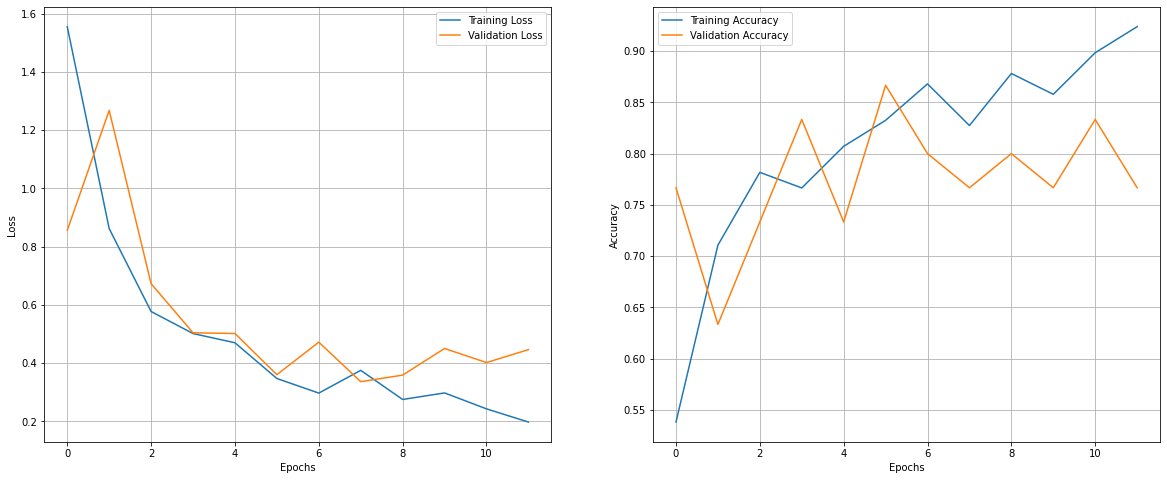

In [ ]:
plt.figure(1, figsize = (20, 8))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( his.history["loss"], label = "Training Loss")
plt.plot( his.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( his.history["accuracy"], label = "Training Accuracy")
plt.plot( his.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

# **Tesing model performance**

In [ ]:
imgs, labels = next(test_generator)

In [ ]:
model= model.load_weights('/content/model22_wg.h5')
y_pred= model.predict(imgs)
y_pred= np.float32(y_pred>0.5)

print(confusion_matrix(labels,y_pred))
print('---------------------------')
print(classification_report(labels,y_pred))
print('---------------------------')
print(accuracy_score(labels,y_pred))

[[11  1]
 [ 6 12]]
---------------------------
              precision    recall  f1-score   support

         0.0       0.65      0.92      0.76        12
         1.0       0.92      0.67      0.77        18

    accuracy                           0.77        30
   macro avg       0.79      0.79      0.77        30
weighted avg       0.81      0.77      0.77        30

---------------------------
0.7666666666666667


# **Evaluation**

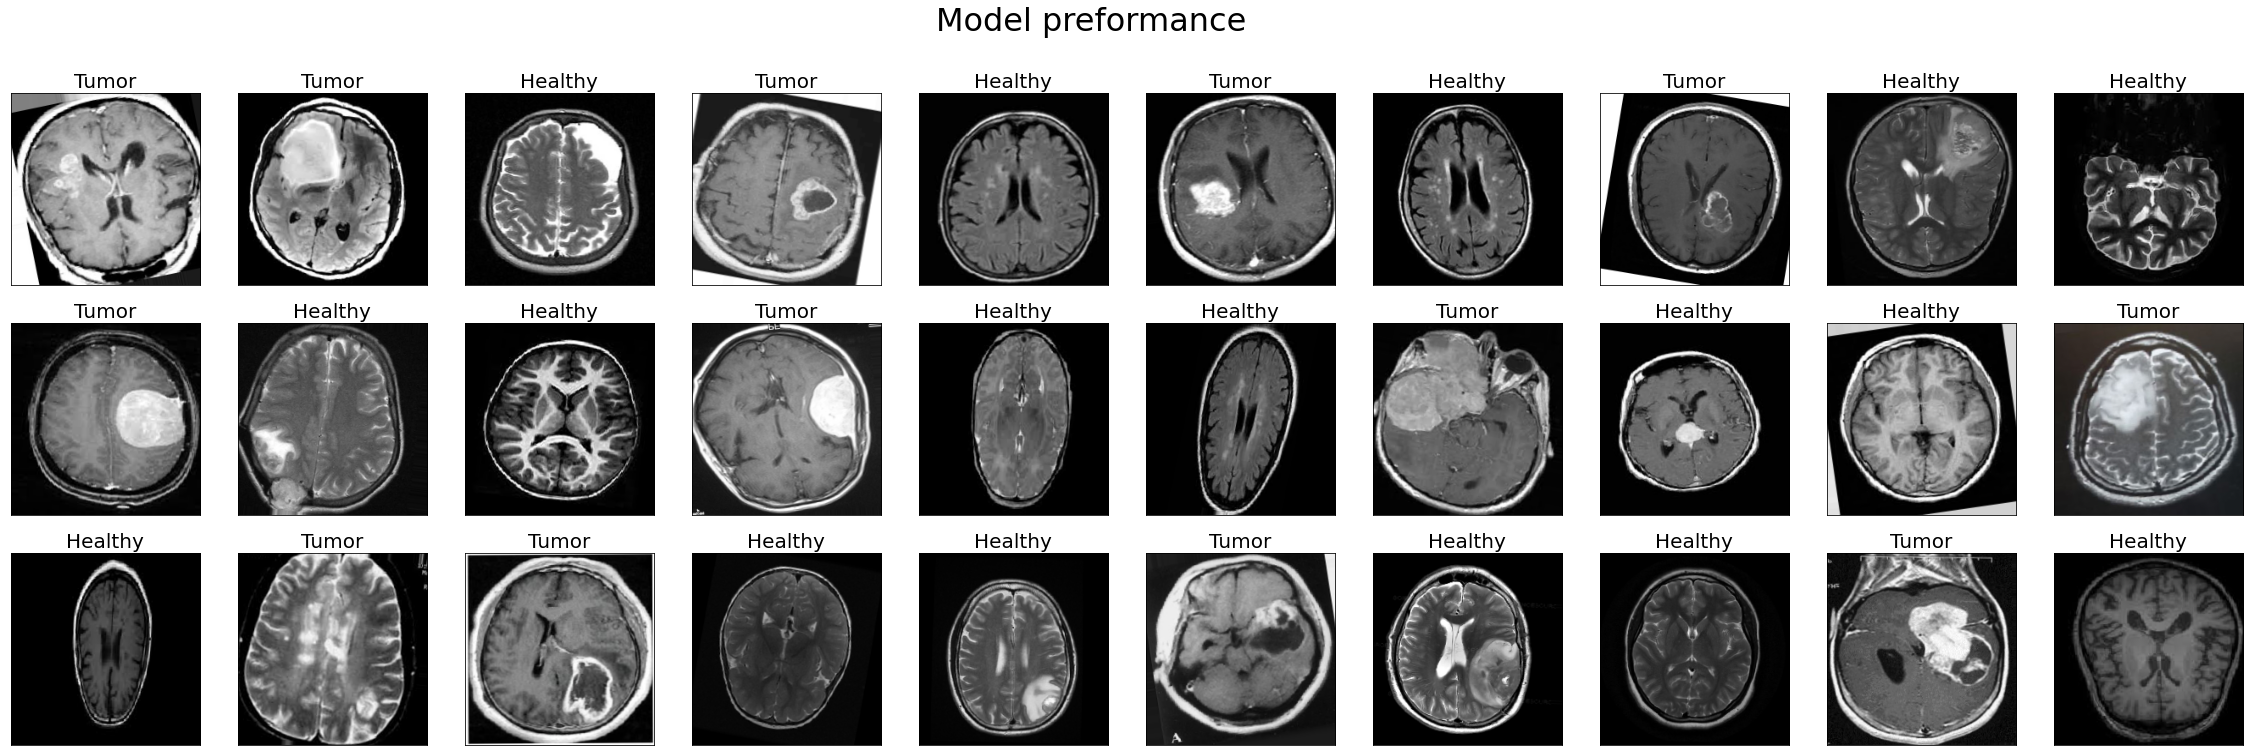

In [ ]:
f, ax= plt.subplots(3, 10, figsize=(40, 12))
grd_truth= {0:'Healthy', 1:'Tumor'}
for i in tqdm(range(30)):
    ax[i//10][i%10].imshow(imgs[i], aspect='auto')
    ax[i//10][i%10].set_xticks([]); ax[i//10][i%10].set_yticks([]); 
    
    pred= int(model.predict(np.expand_dims(imgs[i], 0))>0.5)
    ax[i//10][i%10].set_title(grd_truth[pred], size=20)
    
plt.suptitle('Model preformance', size=32)    
plt.show()